In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint
from boto.s3.connection import S3Connection


%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)

In [4]:
def df_info(df, transpose):
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    nan_df = pd.DataFrame(df.count(), columns=["# NaNs's"])
    nan_df["# NaNs's"] = nan_df["# NaNs's"].apply(lambda row: total_rows - row)
    print "Number of rows: %i" % total_rows
    print "Number of columns: %i" % total_cols
    print "Columns with NaN's: " + "None"
    if nan_df[nan_df["# NaNs's"]>0].empty:
        return
    if transpose:
        print nan_df[nan_df["# NaNs's"]>0].T
    else:
        print nan_df[nan_df["# NaNs's"]>0]
    return

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Setting up S3 connection and getting data

In [6]:
credentials = pd.read_csv('/home/ubuntu/data_science/awscredentials.csv')

s3conn = S3Connection(credentials['AWSAccessKeyId'][0], credentials['AWSSecretKey'][0]) 
yelp_data = s3conn.get_bucket('gads')

review_keys = yelp_data.get_all_keys(prefix='review')
for key in review_keys:
    key.get_contents_to_filename(key.name)

restaurant_keys = yelp_data.get_all_keys(prefix='restaurant')
for key in restaurant_keys:
    key.get_contents_to_filename(key.name)


In [5]:
# only want reviews for restaurants in Phoenix
reviews = pd.DataFrame(pd.read_pickle('review/restaurant_reviews_cleaned.pkl'))
phoenix_restaurants = pd.DataFrame(pd.read_pickle('restaurant/phoenix_restaurants.pkl'))


phoenix_rest_ids = phoenix_restaurants['business_id']
rest_reviews = pd.merge(left=pd.DataFrame(phoenix_rest_ids), right=reviews, how='inner', left_on='business_id', right_on='business_id')

#serialize phoenix reviews for faster load next time
rest_reviews.to_pickle('review/phoenix_reviews.pkl')

rest_reviews.head(10)



,business_id,review_id,date.year,date.month,date.day,stars,text,review_length,votes.cool,votes.funny,votes.useful,user_id
0,x5Mv61CnZLohZWxfCVCPTQ,4ibY4fPQYM7FBSVPrvrYvg,2010,4,2,4,Not the same Domino's pizza I ate too much of ...,375,0,0,0,t95D1tnWvAOy2sxXnI3GUA
1,x5Mv61CnZLohZWxfCVCPTQ,1JlopVxrAeDNQCRnSHLHrQ,2010,5,3,4,Easy ordering-on-line. Made exactly as I asked...,606,0,0,0,t95D1tnWvAOy2sxXnI3GUA
2,x5Mv61CnZLohZWxfCVCPTQ,9--jL__9efnmXZEm9o0HIw,2010,11,2,5,OK OK... as a Proud Italian I hope my momma do...,1722,5,4,4,9ellV9VrEOPA3vX2pZptSA
3,x5Mv61CnZLohZWxfCVCPTQ,TOZMdEyuVnLfkLt6rlxxGA,2011,6,17,2,"So Domino's is Domino's, right? You must know...",1457,1,2,2,UpcVov-qPEKJk6FXl3LLHA
4,x5Mv61CnZLohZWxfCVCPTQ,u-LEH9e8mWPVmolbsXb5rg,2012,9,4,3,never has crushed peppers! \n\nbut the pizza a...,60,0,1,1,NkxFV7RefN87jL_LeVlIPg
5,x5Mv61CnZLohZWxfCVCPTQ,QmMthX1bx6ZHK8PZlvfmSg,2012,9,26,2,"The pizza wasn't horrible, but the deal was a...",198,0,0,2,DBGuQbQy0tPe7Muoawq08Q
6,x5Mv61CnZLohZWxfCVCPTQ,CtRnNJ0JuFDkx_Xu8PAzdw,2013,2,17,1,I normally don't have a problem with Dominos--...,640,1,0,1,L8MoQHZj4cCLKzjeewZvfA
7,x5Mv61CnZLohZWxfCVCPTQ,0m37ZLCausS0gc6TYrcr2A,2013,9,30,2,I don't usually write reviews for chains but t...,314,1,0,3,hn_DclKLzdxABRGGAuqKgg
8,x5Mv61CnZLohZWxfCVCPTQ,3w9IoOVjTTWIZeNG13ZGfA,2014,6,4,5,I have always ordered pizza from dominos and t...,551,0,0,0,lzu5sYkqKRYDHnGGDlHcWw
9,x5Mv61CnZLohZWxfCVCPTQ,WVKPhRNWoj_0aZzYRfWOvQ,2014,9,26,1,Worst customer service ever! The manager Jason...,194,0,0,0,bu2ThJpaNVxXIgclZwpiBw


In [6]:
from tabulate import tabulate

print tabulate(rest_reviews.describe().T, headers="keys")

                 count         mean        std    min    25%    50%    75%    max
-------------  -------  -----------  ---------  -----  -----  -----  -----  -----
date.year       381367  2012.15        1.83421   2005   2011   2013   2014   2015
date.month      381367     6.53556     3.44362      1      4      7      9     12
date.day        381367    15.6973      8.83124      1      8     16     23     31
stars           381367     3.73255     1.28301      1      3      4      5      5
review_length   381367   623.955     585.575        1    234    447    815   5000
votes.cool      381367     0.622196    1.64175      0      0      0      1     89
votes.funny     381367     0.493315    1.51955      0      0      0      0     70
votes.useful    381367     1.10078     2.02081      0      0      0      1     96


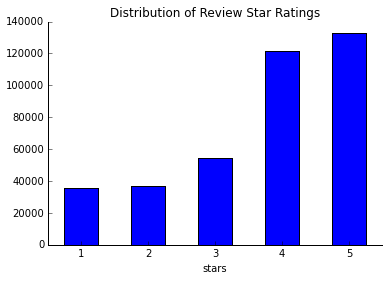

In [7]:
rest_reviews.groupby('stars').stars.count().plot(kind='bar', title='Distribution of Review Star Ratings', grid=False)
plt.setp(plt.xticks()[1], rotation=0)
remove_border()

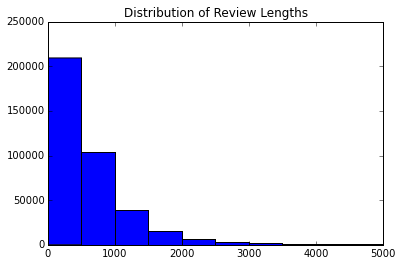

In [8]:
rest_reviews.review_length.describe()
rest_reviews.review_length.hist(grid=False)
plt.title('Distribution of Review Lengths')

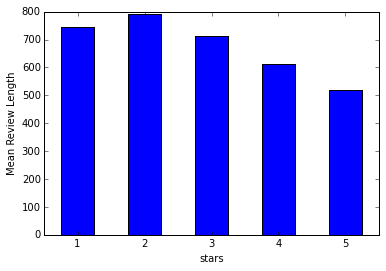

In [10]:
rest_reviews.groupby('stars').review_length.mean().plot(kind='bar', rot=0, grid=False)
plt.ylabel('Mean Review Length')